In [63]:
from graph_tool import *
from graph_tool.draw import *
from graph_tool.stats import *
from graph_tool.topology import *
from graph_tool.clustering import *
from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib notebook

### Mouse Brain Network
https://neurodata.io/project/connectomes/

In [91]:
g1 = load_graph("mouse_brain_1.graphml")
v_names = [g1.vp.name[g1.vertex(i)] for i in g1.get_vertices()]
cmap = plt.get_cmap('plasma')
colors = cmap(np.linspace(0, 1, len(v_names)))
# print(colors[0])
v_prop_color = g1.new_vertex_property("vector<double>")

for i, _ in enumerate(v_names):
    v_prop_color[g1.vertex(i)] = colors[i]
    
pos = sfdp_layout(g1)

<IPython.core.display.Javascript object>


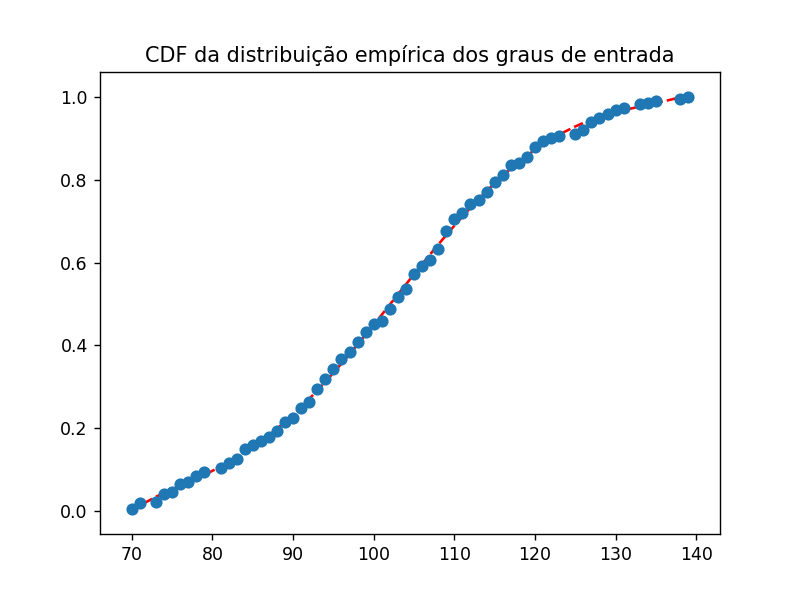

<IPython.core.display.Javascript object>


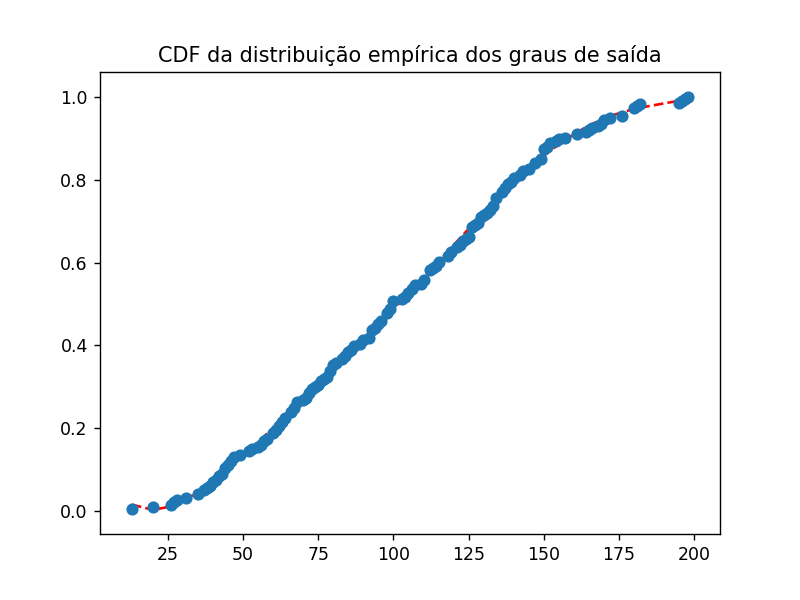

------------------------------------------------------------
Número de vértices: 213
Número de arestas: 21807
Densidade: 0.9658517140579325
------------------------------------------------------------
Grau médio de entrada: 102.38028169014085 +/- 15.564223629774983
Grau mínimo de entrada: 70
Grau máximo de entrada: 139
------------------------------------------------------------
Grau médio de saída: 102.38028169014085 +/- 42.54995391683059
Grau mínimo de saída: 13
Grau máximo de saída: 198
------------------------------------------------------------
Índice de clusterização: 0.7566991799630213 +/- 0.004961638095752927
------------------------------------------------------------
Distância média: 3.0409247940473025 +/- 0.5091288052768413
Distância mínima: 1
Distância máxima: 2
------------------------------------------------------------


In [93]:
mean_degree_in = vertex_average(g1, 'in')
mean_degree_out = vertex_average(g1, 'out')
degrees_in = g1.get_in_degrees(g1.get_vertices())
degrees_out = g1.get_out_degrees(g1.get_vertices())
min_degree_in, max_degree_in, std_degrees_in = min(degrees_in), max(degrees_in), np.std(degrees_in)
min_degree_out, max_degree_out, std_degrees_out = min(degrees_out), max(degrees_out), np.std(degrees_out)
unique_degrees_in, fk_in = np.unique(degrees_in, return_counts=True)
unique_degrees_out, fk_out = np.unique(degrees_out, return_counts=True)

fk_in = fk_in/sum(fk_in)
cdf_fk_in = np.cumsum(fk_in)
p_in = np.poly1d(np.polyfit(unique_degrees_in, cdf_fk_in, 6))

fk_out = fk_out/sum(fk_out)
cdf_fk_out = np.cumsum(fk_out)
p_out = np.poly1d(np.polyfit(unique_degrees_out, cdf_fk_out, 6))

graph_draw(g1, pos=pos, vertex_fill_color=v_prop_color, vertex_color=[0,0,0,1], edge_color=[0,0,0,0.4])

plt.figure()
plt.title("CDF da distribuição empírica dos graus de entrada")
plt.plot(unique_degrees_in, p_in(unique_degrees_in), c='red', linestyle='--')
plt.scatter(unique_degrees_in, cdf_fk_in, zorder=10)
plt.show()

plt.figure()
plt.title("CDF da distribuição empírica dos graus de saída")
plt.plot(unique_degrees_out, p_out(unique_degrees_out), c='red', linestyle='--')
plt.scatter(unique_degrees_out, cdf_fk_out, zorder=10)
plt.show()

clustering = global_clustering(g1)
distances = shortest_distance(g1)
distances = np.array([distances[g1.vertex(v)] for v in g1.get_vertices()]).flatten()
max_edges = comb(len(g1.get_vertices()), 2, exact=False)
min_distance, max_distance = min(distances[distances>0]), max(distances)
mean_distances, std_distances = np.sum(distances)/max_edges, np.std(distances)

print(60*"-")
print("Número de vértices: {0}".format(len(g1.get_vertices())))
print("Número de arestas: {0}".format(len(g1.get_edges())))
print("Densidade: {0}".format(len(g1.get_edges())/max_edges))
print(60*"-")
print("Grau médio de entrada: {0} +/- {1}".format(mean_degree_in[0], std_degrees_in))
print("Grau mínimo de entrada: {0}".format(min_degree_in))
print("Grau máximo de entrada: {0}".format(max_degree_in))
print(60*"-")
print("Grau médio de saída: {0} +/- {1}".format(mean_degree_out[0], std_degrees_out))
print("Grau mínimo de saída: {0}".format(min_degree_out))
print("Grau máximo de saída: {0}".format(max_degree_out))
print(60*"-")
print("Índice de clusterização: {0} +/- {1}".format(clustering[0], clustering[1]))
print(60*"-")
print("Distância média: {0} +/- {1}".format(mean_distances, std_distances))
print("Distância mínima: {0}".format(min_distance))
print("Distância máxima: {0}".format(max_distance))
print(60*"-")

### Contacts in a workplace
http://www.sociopatterns.org/datasets/contacts-in-a-workplace/

In [95]:
f = open("tij_InVS.dat", "r")
lines = np.array([[int(n) for n in x.split()] for x in f.readlines()])
f.close()
pairs = lines[:,1:]

unique, counts  = np.unique(pairs, axis=0, return_counts=True)
np.expand_dims(counts, axis=1).shape
pairs_interaction = np.concatenate((unique, np.expand_dims(counts, axis=1)), axis=1)

f = open("metadata_InVS13.txt", "r")
deps = np.array([[int(x.split()[0]), x.split()[1]] for x in f.readlines()])
f.close()

vertices_dict = {}
v_color_dict = {'DISQ':'red' ,'DMCT':'blue', 'DSE':'yellow', 'SFLE':'green', 'SRH':'gray'}

g2 = Graph(directed=False)
v_prop_department = g2.new_vertex_property("string")
e_prop_weight = g2.new_edge_property("int")

for i,(v, d) in enumerate(deps):
    v_prop_department[g2.add_vertex()] = v_color_dict[d]
    vertices_dict[int(v)] = i

for i, v in enumerate(pairs_interaction):
    v1, v2 = vertices_dict[v[0]], vertices_dict[v[1]]
    e_prop_weight[g2.add_edge(v1,v2)] = pairs_interaction[i,2]

    
pos = sfdp_layout(g2)

<IPython.core.display.Javascript object>


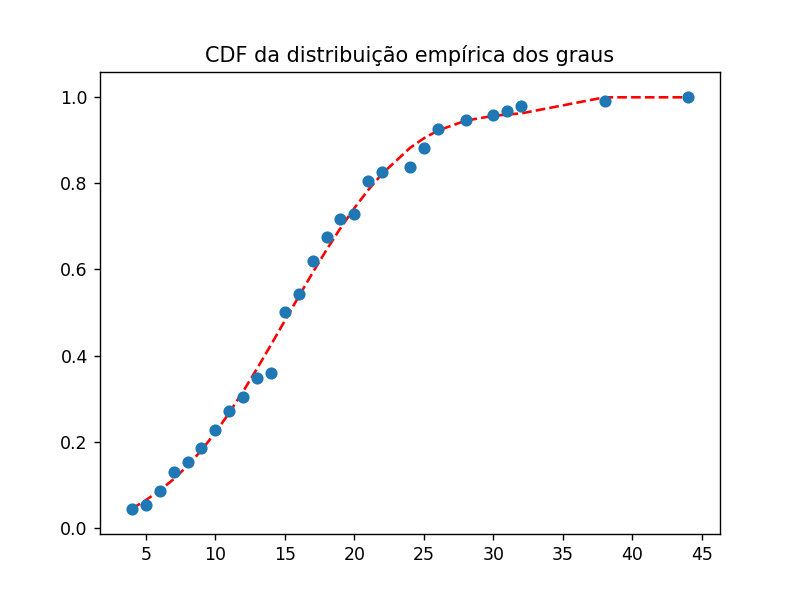

------------------------------------------------------------
Número de vértices: 92
Número de arestas: 755
Densidade: 0.03343963149968996
------------------------------------------------------------
Grau médio: 16.41304347826087 +/- 7.570182029160948
Grau mínimo: 4
Grau máximo: 44
------------------------------------------------------------
Índice de clusterização: 0.36824774048903525 +/- 0.012863291957447887
------------------------------------------------------------
Distância média: 3.928810320114668 +/- 0.6015252659627888
Distância mínima: 1
Distância máxima: 3
------------------------------------------------------------


In [96]:
mean_degree = vertex_average(g2, 'total')
degrees = g2.get_out_degrees(g2.get_vertices())
min_degree, max_degree, std_degrees = min(degrees), max(degrees), np.std(degrees)
unique_degrees, fk = np.unique(degrees, return_counts=True)

fk = fk/sum(fk)
cdf_fk = np.cumsum(fk)
p = np.poly1d(np.polyfit(unique_degrees, cdf_fk, 6))

graph_draw(g2, pos=pos, vertex_fill_color=v_prop_department, vertex_color=[0,0,0,1], edge_color=[0,0,0,0.4])

plt.figure()
plt.title("CDF da distribuição empírica dos graus")
plt.plot(unique_degrees, p(unique_degrees), c='red', linestyle='--')
plt.scatter(unique_degrees, cdf_fk, zorder=10)
plt.show()

clustering = global_clustering(g2)
distances = shortest_distance(g2)
distances = np.array([distances[g2.vertex(v)] for v in g2.get_vertices()]).flatten()
min_distance, max_distance = min(distances[distances>0]), max(distances)
mean_distances, std_distances = np.sum(distances)/comb(len(g2.get_vertices()), 2, exact=False), np.std(distances)

print(60*"-")
print("Número de vértices: {0}".format(len(g2.get_vertices())))
print("Número de arestas: {0}".format(len(g2.get_edges())))
print("Densidade: {0}".format(len(g2.get_edges())/max_edges))
print(60*"-")
print("Grau médio: {0} +/- {1}".format(mean_degree[0], std_degrees))
print("Grau mínimo: {0}".format(min_degree))
print("Grau máximo: {0}".format(max_degree))
print(60*"-")
print("Índice de clusterização: {0} +/- {1}".format(clustering[0], clustering[1]))
print(60*"-")
print("Distância média: {0} +/- {1}".format(mean_distances, std_distances))
print("Distância mínima: {0}".format(min_distance))
print("Distância máxima: {0}".format(max_distance))
print(60*"-")

### Power Grid
http://networksciencebook.com/translations/en/resources/data.html

In [94]:
g3 = load_graph("barabasi-networks/powergrid.xml")
pos = sfdp_layout(g3)

<IPython.core.display.Javascript object>


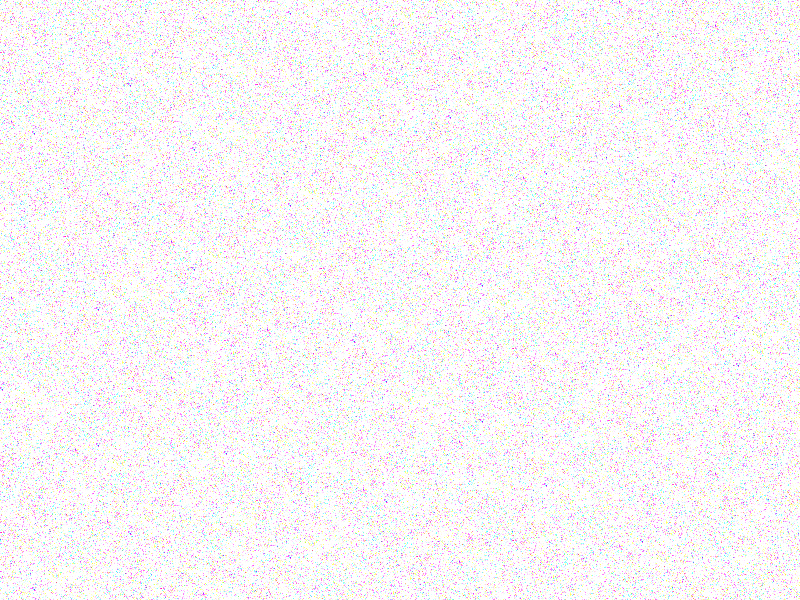

------------------------------------------------------------
Grau médio: 2.66909532483303 +/- 0.025483212389547604
Grau mínimo: 1
Grau máximo: 19
Desvio Padrão dos graus: 1.7912722617587216
------------------------------------------------------------
Índice de clusterização: 0.10315322452860086 +/- 0.004104729312315684
------------------------------------------------------------
Distância média: 37.978370848891416
Distância mínima: 0
Distância máxima: 46
Desvio Padrão das distâncias: 6.512499830950978
------------------------------------------------------------


In [64]:
mean_degree = vertex_average(g3, 'total')
degrees = g3.get_out_degrees(g3.get_vertices())
min_degree, max_degree, std_degrees = min(degrees), max(degrees), np.std(degrees)
unique_degrees, fk = np.unique(degrees, return_counts=True)

fk = fk/sum(fk)
cdf_fk = np.cumsum(fk)
p = np.poly1d(np.polyfit(unique_degrees, cdf_fk, 7))

graph_draw(g3, pos=pos, vertex_color=[0,0,0,1], edge_color=[0,0,0,1])

plt.figure()
plt.title("CDF da distribuição empírica dos graus")
plt.plot(unique_degrees, p(unique_degrees), c='red', linestyle='--')
plt.scatter(unique_degrees, cdf_fk, zorder=10)
plt.show()

clustering = global_clustering(g3)
distances = shortest_distance(g3)
distances = np.array([distances[g3.vertex(v)] for v in g3.get_vertices()]).flatten()
min_distance, max_distance = min(distances[distances>0]), max(distances)
mean_distances, std_distances = np.sum(distances)/comb(len(g3.get_vertices()), 2, exact=False), np.std(distances)

print(60*"-")
print("Número de vértices: {0}".format(len(g3.get_vertices())))
print("Número de arestas: {0}".format(len(g3.get_edges())))
print("Densidade: {0}".format(len(g3.get_edges())/max_edges))
print(60*"-")
print("Grau médio: {0} +/- {1}".format(mean_degree[0], std_degrees))
print("Grau mínimo: {0}".format(min_degree))
print("Grau máximo: {0}".format(max_degree))
print(60*"-")
print("Índice de clusterização: {0} +/- {1}".format(clustering[0], clustering[1]))
print(60*"-")
print("Distância média: {0} +/- {1}".format(mean_distances, std_distances))
print("Distância mínima: {0}".format(min_distance))
print("Distância máxima: {0}".format(max_distance))
print(60*"-")

### Italian Gangs
https://sites.google.com/site/ucinetsoftware/datasets/covert-networks/italiangangs

In [97]:
nodes = np.genfromtxt("ITALIAN_GANGS.csv", delimiter=",", skip_header=True)
adj = nodes[:,1:]

countries = np.genfromtxt("ITALIAN_GANGS_ATTR.csv", delimiter=",", skip_header=True)
countries = countries[:,1].astype(int)

unique_countries, counts  = np.unique(countries, axis=0, return_counts=True)

D = nx.Graph(adj)
edge_list = nx.to_edgelist(D)
edge_list = [[e[0], e[1]] for e in edge_list]

g4 = Graph(directed=False)
g4.add_edge_list(edge_list)

cmap = plt.get_cmap('tab10')
colors = cmap(np.linspace(0, 1, len(unique_countries)))
v_prop_color = g4.new_vertex_property("vector<double>")

for i, _ in enumerate(g4.get_vertices()):
    v_prop_color[g4.vertex(i)] = colors[countries[i]-1]
    
pos = sfdp_layout(g4)

<IPython.core.display.Javascript object>


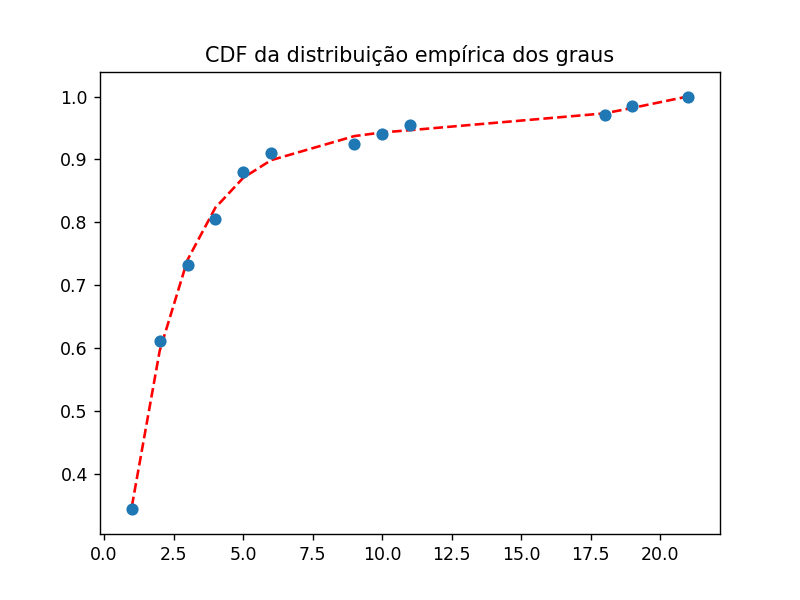

[0 0 4 ... 3 5 0]
------------------------------------------------------------
Número de vértices: 67
Número de arestas: 114
Densidade: 0.005049162901939941
------------------------------------------------------------
Grau médio: 3.4029850746268657 +/- 4.044748581720435
Grau mínimo: 1
Grau máximo: 21
------------------------------------------------------------
Índice de clusterização: 0.20802919708029197 +/- 0.05658929329187625
------------------------------------------------------------
Distância média: 5.668023518769788 +/- 1.262429998142447
Distância mínima: 1
Distância máxima: 6
------------------------------------------------------------


In [98]:
mean_degree = vertex_average(g4, 'total')
degrees = g4.get_out_degrees(g4.get_vertices())
min_degree, max_degree, std_degrees = min(degrees), max(degrees), np.std(degrees)
unique_degrees, fk = np.unique(degrees, return_counts=True)

fk = fk/sum(fk)
cdf_fk = np.cumsum(fk)
p = np.poly1d(np.polyfit(unique_degrees, cdf_fk, 7))

graph_draw(g4, pos=pos, vertex_fill_color=v_prop_color, vertex_color=[0,0,0,1], edge_color=[0,0,0,0.4])

plt.figure()
plt.title("CDF da distribuição empírica dos graus")
plt.plot(unique_degrees, p(unique_degrees), c='red', linestyle='--')
plt.scatter(unique_degrees, cdf_fk, zorder=10)
plt.show()

clustering = global_clustering(g4)
distances = shortest_distance(g4)
distances = np.array([distances[g3.vertex(v)] for v in g4.get_vertices()]).flatten()
distances[distances == np.iinfo('int32').max] = 0
min_distance, max_distance = min(distances[distances>0]), max(distances)
mean_distances, std_distances = np.sum(distances)/comb(len(g4.get_vertices()), 2, exact=False), np.std(distances)

print(60*"-")
print("Número de vértices: {0}".format(len(g4.get_vertices())))
print("Número de arestas: {0}".format(len(g4.get_edges())))
print("Densidade: {0}".format(len(g4.get_edges())/max_edges))
print(60*"-")
print("Grau médio: {0} +/- {1}".format(mean_degree[0], std_degrees))
print("Grau mínimo: {0}".format(min_degree))
print("Grau máximo: {0}".format(max_degree))
print(60*"-")
print("Índice de clusterização: {0} +/- {1}".format(clustering[0], clustering[1]))
print(60*"-")
print("Distância média: {0} +/- {1}".format(mean_distances, std_distances))
print("Distância mínima: {0}".format(min_distance))
print("Distância máxima: {0}".format(max_distance))
print(60*"-")